In [1]:
from pathlib import Path
import sys

cwd = Path.cwd()
for root in [cwd, *cwd.parents]:
    src_path = root / 'src'
    if (src_path / 'replenishment').exists():
        sys.path.insert(0, str(src_path))
        break
    src_path = root / 'replenishment' / 'src'
    if (src_path / 'replenishment').exists():
        sys.path.insert(0, str(src_path))
        break

for name in list(sys.modules):
    if name == 'replenishment' or name.startswith('replenishment.'):
        del sys.modules[name]


In [2]:
from dataclasses import replace
import random

from replenishment import (
    build_lead_time_forecast_article_configs_from_standard_rows,
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_point_forecast_policy_and_simulate_actuals,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)


# Mean Forecast Policy Variants


This notebook compares two mean-forecast policies:  
- **Point forecast at t+L** (current policy)  
- **Lead-time sum forecast** (new policy)  

Both are evaluated with:  
1) fixed aggregation window (window=1)  
2) joint optimization of sigma + aggregation window.


## 1) Generate Sample Data


In [31]:
history_mean = 20.0
history_std = 5.0
forecast_mean = 15.0
forecast_std = 4.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=60,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=30,
    lead_time=3,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.50, .55, .60, .65, .70, .75, .80, .85, .90, .95, .99]
candidate_windows = [1, 2, 3, 4]
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)


backtest rows: 6000, forecast rows: 6000


## 2) Fixed Aggregation Window (window=1)


### 2.1 Point forecast at t+L (current policy)


In [32]:
point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)


In [33]:
point_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
point_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2026-06-19,25,19,17,0,30,11,6.684821,30,11,11,25,0,0,0.7,1,None
1,A,2026-07-19,19,23,18,0,11,0,6.684821,11,0,0,44,12,12,0.7,1,None
2,A,2026-08-18,17,19,13,0,0,0,6.684821,0,0,0,61,31,19,0.7,1,None
3,A,2026-09-17,28,18,18,25,25,7,6.684821,0,0,7,64,24,0,0.7,1,None
4,A,2026-10-17,15,15,12,19,26,11,6.684821,0,0,11,60,20,0,0.7,1,None


0      0
1     12
2     19
3      0
4      0
5      0
6      0
7      0
8      0
9      1
10     4
11     0
12     0
13     0
14     0
15     1
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

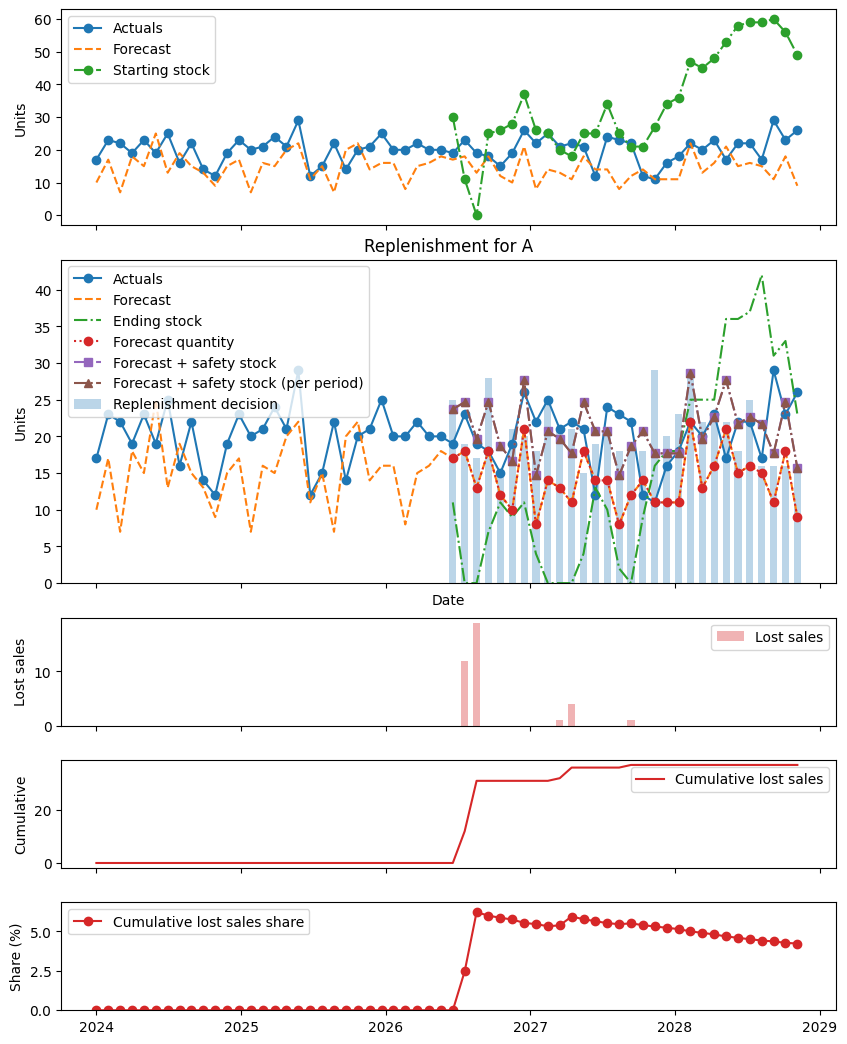

In [34]:
example_id = point_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, point_decisions_df, unique_id=example_id)


### 2.2 Lead-time sum forecast (new policy)


In [45]:
lt_configs = build_lead_time_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)
lt_optimized = optimize_service_level_factors(
    lt_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
lt_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in lt_optimized.items()
}

lt_eval_configs = build_lead_time_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=lt_best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
lt_eval_simulations = simulate_replenishment_for_articles(lt_eval_configs)
lt_eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    lt_eval_simulations,
    sigma=lt_best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)


In [46]:
lt_decisions_df = replenishment_decision_rows_to_dataframe(lt_eval_decisions)
lt_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2026-06-19,48,19,17,0,30,11,0.0,30,11,11,48,0,0,0.5,1,None
1,A,2026-07-19,49,23,18,0,11,0,0.0,11,0,0,97,12,12,0.5,1,None
2,A,2026-08-18,43,19,13,0,0,0,0.0,0,0,0,140,31,19,0.5,1,None
3,A,2026-09-17,40,18,18,48,48,30,0.0,17,0,30,132,1,0,0.5,1,None
4,A,2026-10-17,43,15,12,49,79,64,0.0,48,33,64,126,0,0,0.5,1,None


0      0
1     12
2     19
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

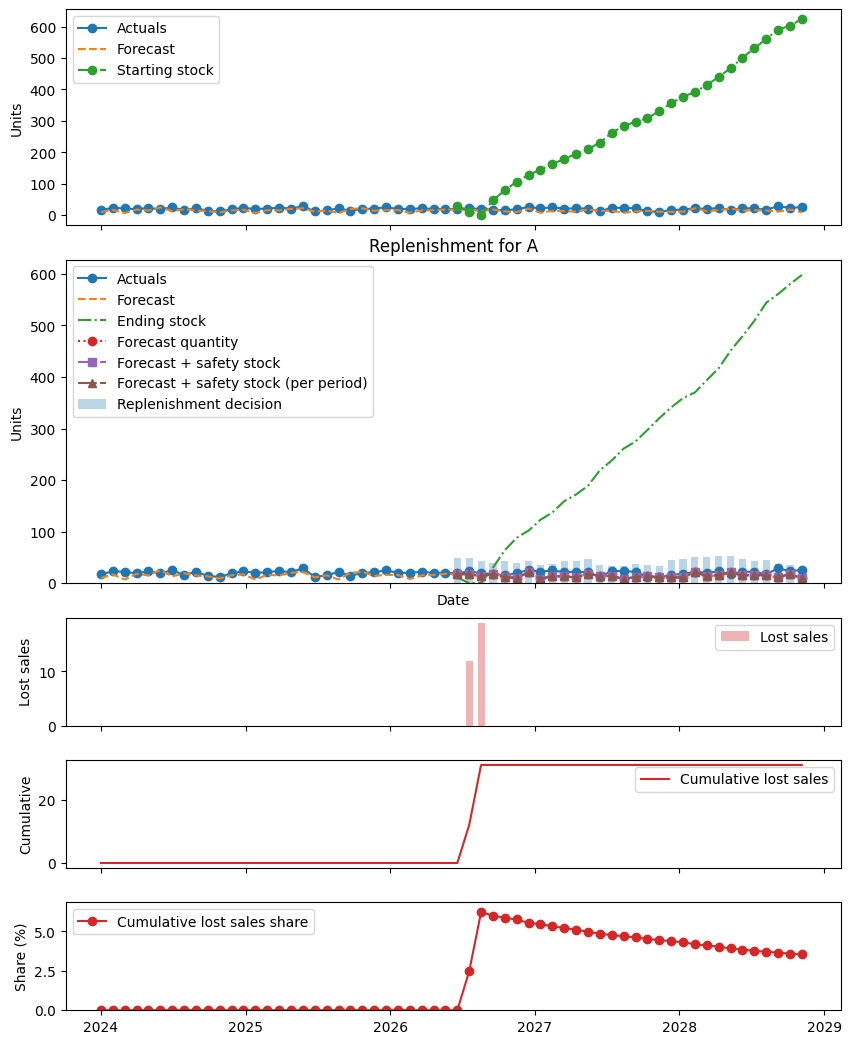

In [47]:
example_id = lt_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, lt_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


### 3.1 Point forecast at t+L (current policy)


In [38]:
candidate_service_levels

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

In [39]:
point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.99,
    service_level_mode="service_level",
)
agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows, aggregation_window=agg_windows
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


In [40]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2026-06-19,63,61,48,0,30,0,22.304152,30,0,0,63,31,31,0.9,3,None
1,A,2026-09-17,66,52,40,63,63,11,22.304152,32,0,11,66,20,0,0.9,3,None
2,A,2026-12-16,65,73,43,66,77,4,22.304152,46,0,4,65,27,0,0.9,3,None
3,A,2027-03-16,59,64,42,65,69,5,22.304152,38,0,5,59,26,0,0.9,3,None
4,A,2027-06-14,60,59,36,59,64,5,22.304152,33,0,5,60,26,0,0.9,3,None


0    31
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

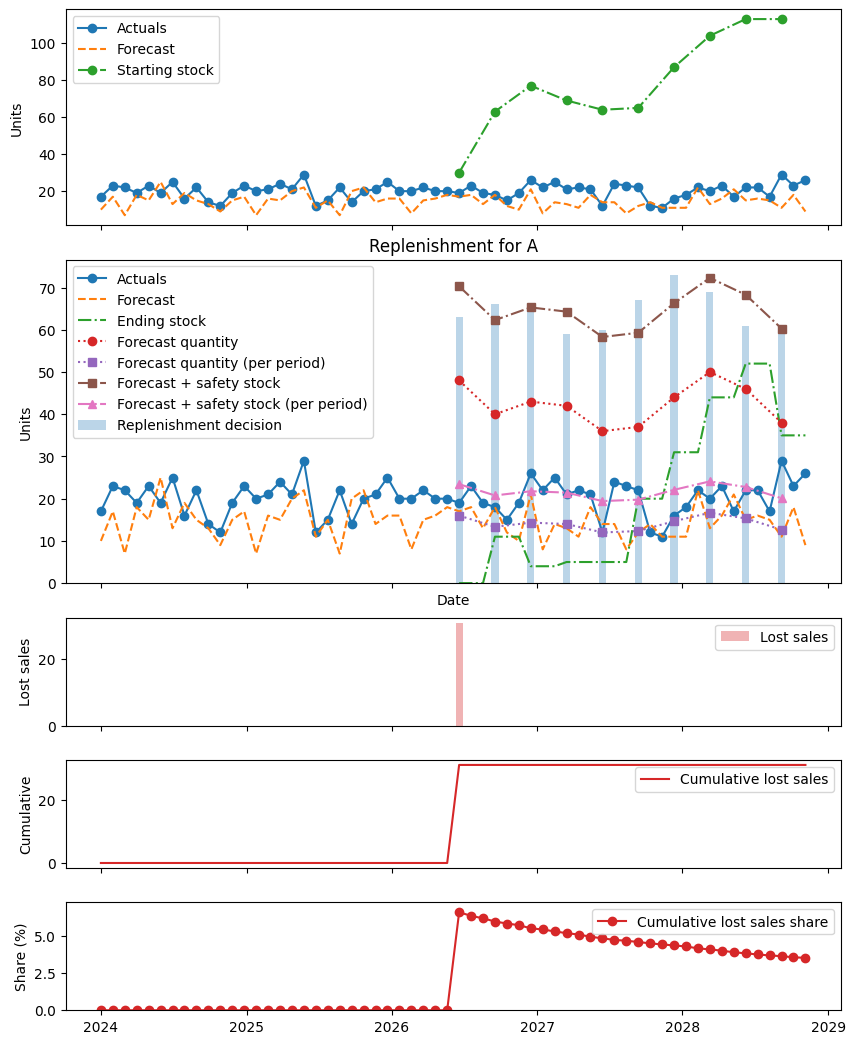

In [41]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### 3.2 Lead-time sum forecast (new policy)


In [42]:
lt_point_configs = build_lead_time_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
)
lt_agg_result = optimize_aggregation_and_service_level_factors(
    lt_point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
lt_agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in lt_agg_result.items()
}
lt_agg_windows = {
    unique_id: result.window
    for unique_id, result in lt_agg_result.items()
}

lt_agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows, aggregation_window=lt_agg_windows
)

lt_forecast_configs = build_lead_time_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=lt_agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=lt_agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
lt_agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=lt_agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in lt_forecast_configs.items()
}
lt_agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    lt_agg_simulations,
    aggregation_window=lt_agg_windows,
    sigma=lt_agg_best_factors,
    fixed_rmse=lt_agg_backtest_rmse,
    service_level_mode="service_level",
)


In [43]:
lt_agg_decisions_df = replenishment_decision_rows_to_dataframe(lt_agg_decisions)
lt_agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2026-06-19,71,61,48,0,30,0,22.304152,30,0,0,71,31,31,0.9,3,None
1,A,2026-09-17,63,52,40,71,71,19,22.304152,40,0,19,63,12,0,0.9,3,None
2,A,2026-12-16,66,73,43,63,82,9,22.304152,51,0,9,66,22,0,0.9,3,None
3,A,2027-03-16,65,64,42,66,75,11,22.304152,44,0,11,65,20,0,0.9,3,None
4,A,2027-06-14,59,59,36,65,76,17,22.304152,45,0,17,59,14,0,0.9,3,None


0    31
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

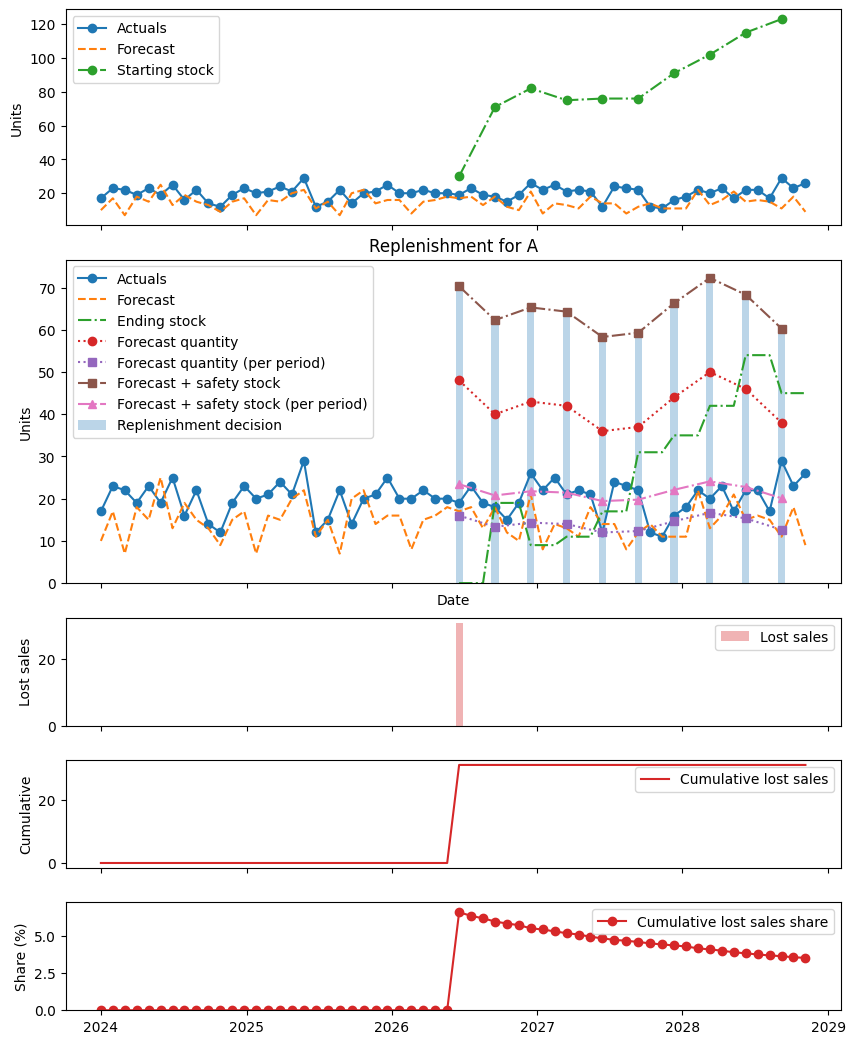

In [44]:
example_id = lt_agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, lt_agg_decisions_df, unique_id=example_id)